In [6]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def read_data(name:str):
    if name[-4:] == 'step' or name[-4:] == 'eval':
        raw_name = name[:-4]
    else:
        raw_name = name
    
    with open(f'./results/{raw_name}step.pkl', 'rb') as f:
        steps = pickle.load(f)
        if type(steps) is dict:
            steps = steps['latency']
    
    evals = None

    try:
        with open(f'./results/{raw_name}eval.pkl', 'rb') as f:
            evals = pickle.load(f)
            if type(evals) is list and type(evals[0]) is dict:
                evals = [np.mean(i['latency']) for i in evals]
    except:
        print('eval file not found')
    
    return steps, evals

In [34]:
def cal_r_avg(data, beta=0.98, bias_correction=True):
    runing_averge = []
    curr = 0
    for i in range(len(data)):
        curr = beta*curr + (1-beta)*data[i]
        correction = 1 - (beta**(i+1))
        if bias_correction:
            runing_averge.append(curr / correction)
        else:
            runing_averge.append(curr)
    
    return runing_averge

In [35]:
def log_transform(data):
    if data[0] < 0:
        return -np.log(np.abs(data))
    else:
        return np.log(data)

In [23]:
steps, evals = read_data('li_Wolpertinger_cSim_3_step')

In [24]:
max(steps)

-29.252508899997036

In [102]:
def illustrate(step_data, eval_data=None, ra_plot=True, ra_only=True, name='', c=''):
    time_step = time_step = list(range(len(step_data)))

    if not ra_only:
        plt.plot(time_step, step_data)

    if ra_plot:
        if c != '':
            plt.plot(time_step, cal_r_avg(step_data), linewidth=2, label=name, c=c)
        else:
            plt.plot(time_step, cal_r_avg(step_data), linewidth=2, label=name)
    
    if eval_data is not None:
        eval_step = len(step_data)//len(eval_data)
        eval_range = [i+eval_step for i in range(0, len(steps), eval_step)]
        plt.plot(eval_range, eval_data, linewidth=2)

In [43]:
def illustrate_real_step(step_data, n=15):
    real_step = np.array(step_data).reshape((-1,n))
    real_step_mean = np.mean(real_step, axis=1)
    real_step_upper = np.max(real_step, axis=1)
    real_step_lower = np.min(real_step, axis=1)
    real_time_step = list(range(0, len(real_step)*n, n))
    plt.plot(real_time_step, real_step_mean)
    plt.show()

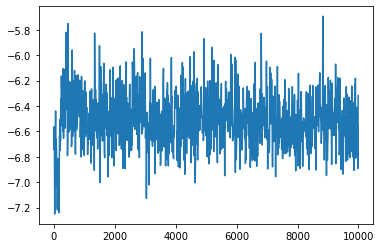

In [45]:
illustrate_real_step(log_transform(steps), n=10)

In [127]:
plt.style.use(['seaborn-darkgrid'])

# Small Scale Condense v.s. Wolpertinger (WordCounting)

In [128]:
con_small_steps, _ = read_data('parallel_TD3_cSim_condense_0_eval')
con_small_steps = con_small_steps[:3000]
li_wolp_small_steps, _ = read_data('li_Wolpertinger_cSim_3_eval')
li_wolp_small_steps = li_wolp_small_steps[:3000]
li_wolp_small_steps_correct, _ = read_data('li_Wolpertinger_cSim_2_eval')
our_wolp_small_steps, _ = read_data('our_Wolpertinger_cSim_2_eval')

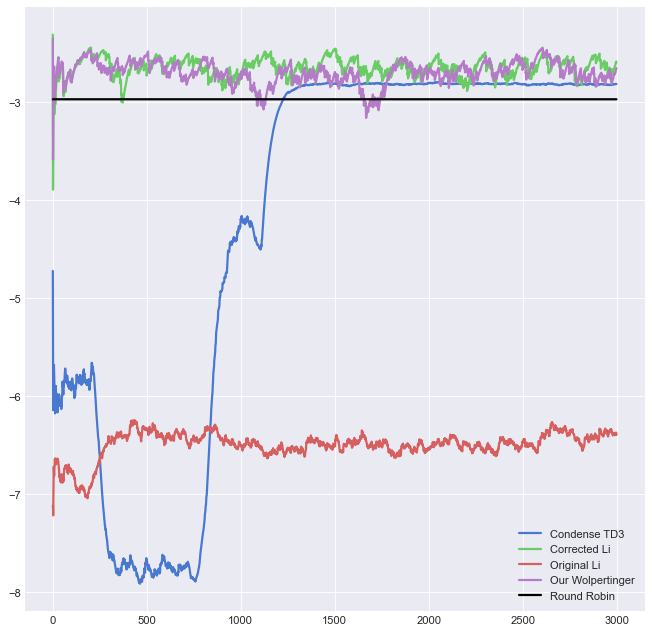

In [129]:
# we might re-run this part for the new simulator architecture
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(con_small_steps)*0.95, name='Condense TD3')
illustrate(log_transform(li_wolp_small_steps_correct), name='Corrected Li')
illustrate(log_transform(li_wolp_small_steps), name='Original Li')
illustrate(log_transform(our_wolp_small_steps), name='Our Wolpertinger')
illustrate(log_transform([-19.5]*len(con_small_steps)), name='Round Robin', c='black')
plt.legend()
plt.show()

# Large scale Wolpertinger v.s. Li (WordCounting)

In [130]:
li_wolp_large_steps, _ = read_data('li_Wolpertinger_cSim_3_eval')
con_td3_large_steps, _ = read_data('parallel_TD3_cSim_condense_large_infi_1_eval')
li_wolp_large_steps = li_wolp_large_steps[3000:3000+len(con_large_steps)]
con_ddpg_large_steps, _ = read_data('parallel_DDPG_cSim_condense_large_infi_2_eval')

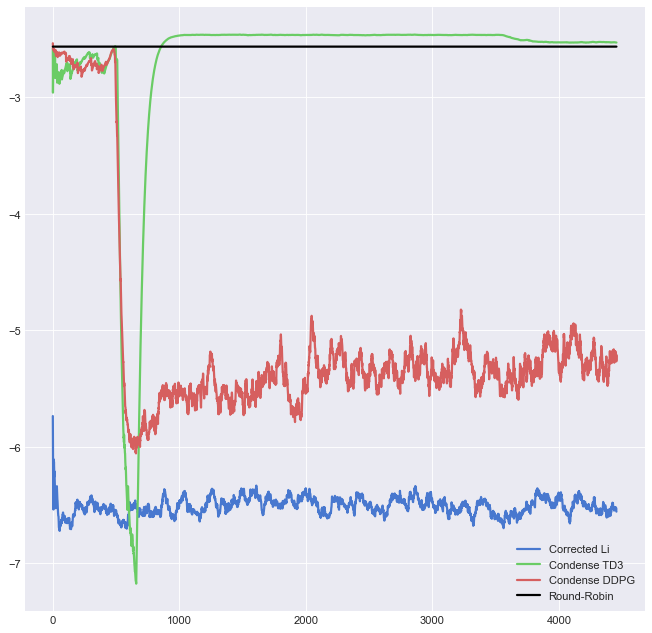

In [131]:
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(li_wolp_large_steps), name='Corrected Li')
illustrate(log_transform(con_td3_large_steps), name='Condense TD3')
illustrate(log_transform(con_ddpg_large_steps), name='Condense DDPG')
illustrate(log_transform([-13]*len(con_td3_large_steps)), name='Round-Robin', c='black')
plt.legend()
plt.show()

# Poisson Sampler + Mimic Field Group (and generalisability)

In [156]:
td3_possion_step, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_complex_2_eval')
td3_possion_step_gen, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_complex_general_0_step')

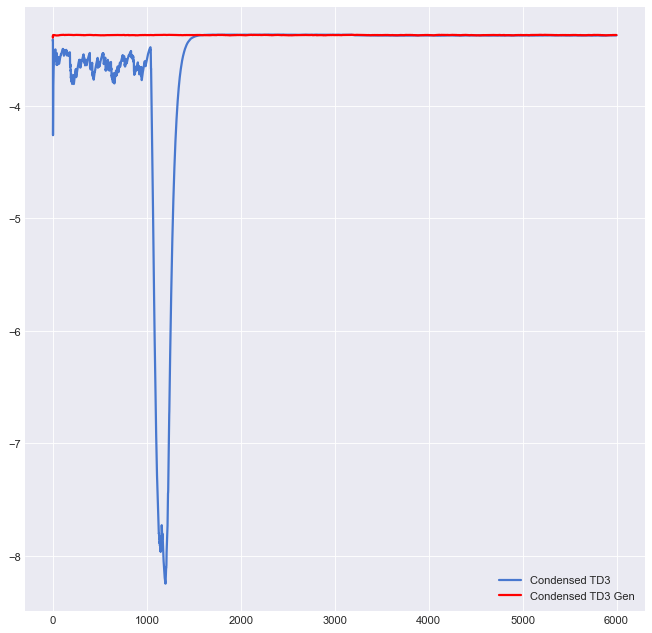

In [175]:
plt.figure(figsize=(10,10), dpi=80)
# re-run this to obtain some results
illustrate(log_transform(td3_possion_step)-0.59, name='Condensed TD3')
illustrate(log_transform(td3_possion_step_gen*3), name='Condensed TD3 Gen', c='r')
plt.legend()
plt.show()

# Offline

# Complex Log

In [133]:
td3_complex, _ = read_data('parallel_TD3_cSim_condense_complex_log_0_eval')

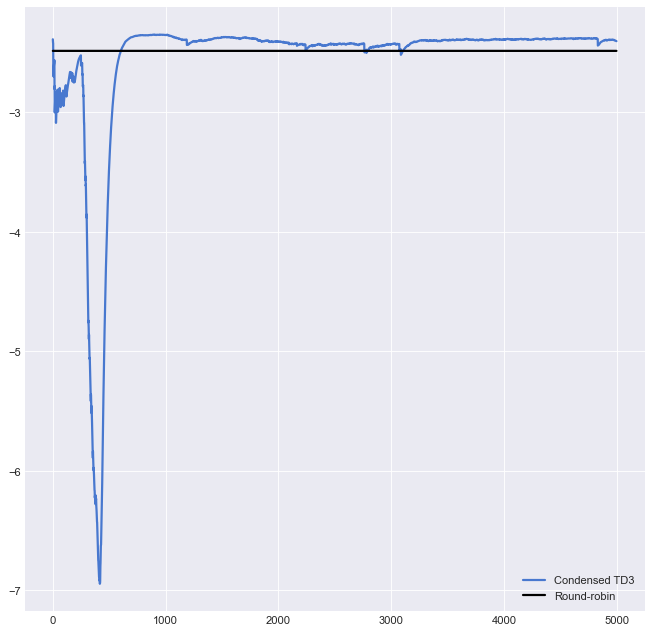

In [144]:
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(td3_complex), name='Condensed TD3')
illustrate(log_transform([-12]*len(td3_complex)), name='Round-robin', c='black')
plt.legend()
plt.show()

# Heterogeneous Machines + Field Grouping + Poisson

In [146]:
poi_heter_step, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_heter_0_step')

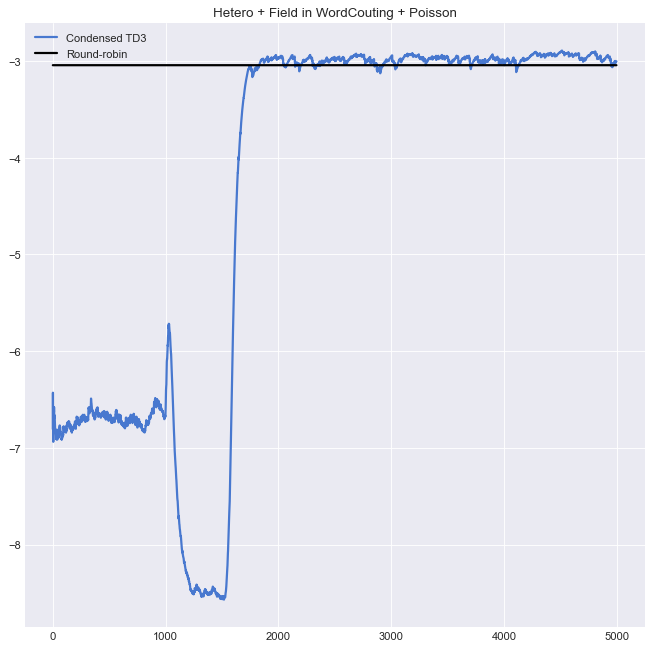

In [153]:
plt.figure(figsize=(10,10), dpi=80)
plt.title('Hetero + Field in WordCouting + Poisson')
illustrate(log_transform(poi_heter_step), name='Condensed TD3')
illustrate(log_transform([-21]*len(poi_heter_step)), name='Round-robin', c='black')
plt.legend()
plt.show()

In [154]:
poi_complex_heter, _ = read_data('parallel_TD3_cSim_condense_complex_log_heter_1_eval')

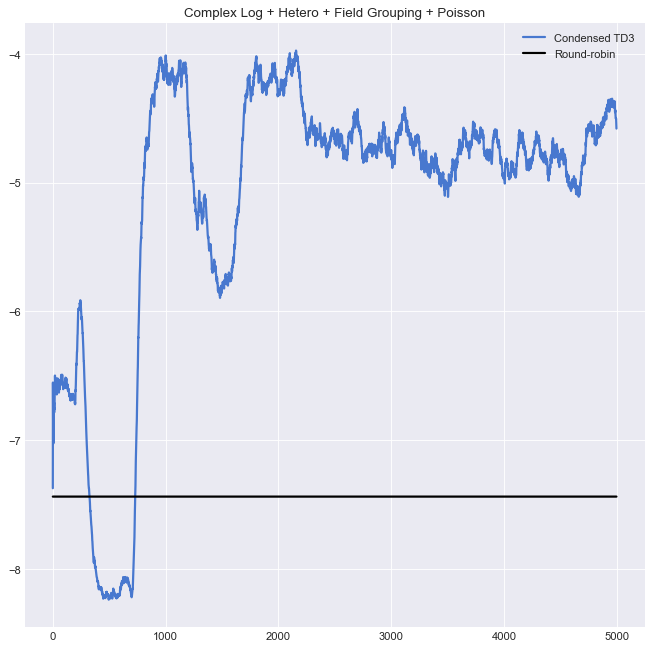

In [155]:
plt.figure(figsize=(10,10), dpi=80)
plt.title('Complex Log + Hetero + Field Grouping + Poisson')
illustrate(log_transform(poi_complex_heter), name='Condensed TD3')
illustrate(log_transform([-1700]*len(poi_heter_step)), name='Round-robin', c='black')
plt.legend()
plt.show()